In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import gsw

from shapely.geometry import LineString, Polygon, Point
from shapely.ops import polygonize, unary_union
from shapely.validation import explain_validity

from scipy.interpolate import griddata
from salishsea_tools import unit_conversions
from salishsea_tools import psu_tools
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


IOPATH = '/ocean/ghoeven/MOAD/Data/PNW_obs_compiled.csv'

In [2]:
ds = xr.open_dataset("/ocean/ghoeven/MOAD/Data/gebco_2023.nc")

In [3]:
obs = pd.read_csv(IOPATH)
obs['current'] = np.nan

grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')

In [4]:
# Salish Sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [5]:
# 500m Depth cuttoff
# for the sake of looking at what ACTUALLY gets into the salish sea, can cuttoff at 500 m
# this reasonning is that the CC flows in the top 500, and the CUC core is around 200 m

ind = np.where(obs['depth (m)'] > 500) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)



In [6]:
# Lat and lon cuttoff
xlim, ylim = [-145.5, -120.2], [30, 60]

ind = np.where(obs['latitude (degrees_north)'] > ylim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['latitude (degrees_north)'] < ylim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] > xlim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] < xlim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [7]:
# Remove Washington Dept of Ecology and ONC data as they consist of river and salish sea data (not offshore so not relevant)
ind = np.where(obs['source'] == 'department of ecology') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)
ind = np.where(obs['source'] == 'onc') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [8]:
for s in set(obs.source):
    print(s)
    print(len(obs[obs.source==s]))
    print('\n')

ios bottle
152728


NCEI Salish
464


ios ctd profiles, ios bottle
766


ooi
50567


NCEI PNW
977


ios bottle, GEOTRACES
179


ios bottle, NCEI PNW, GEOTRACES
3


ios bottle, NCEI PNW
406


ios mooring, ios bottle
9


ios ctd profiles
62649


OCNMS
46231


GEOTRACES
360


ios mooring
185224


NCEI Coastal
6128


NCEI Coastal, NHL
10


NHL
495859


CALCOFI
196413




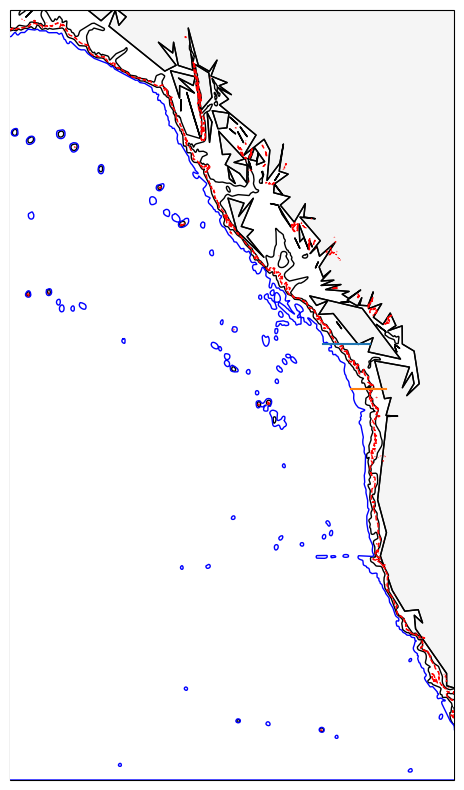

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='b',zorder=4))

elev = ds.elevation
mask = ~((ds.lon > -124.5) & (ds.lon < -122.0) & (ds.lat > 47.5) & (ds.lat < 49.5))
elev_masked = elev.where(mask)

# Add custom 500m isobath from GEBCO
cs = ax.contour(ds.lon, ds.lat, elev_masked, levels=[-500],
                colors='r', linewidths=1, transform=crs.PlateCarree(), zorder=5)
#ax.clabel(cs, fmt='%d m', fontsize=8)

# offshore cuttoff 
# y=np.linspace(42,52,100)
# x = np.sqrt((1-((y-42)**2)/(9**2))*(6**2))-130.8
# ax.plot(x,y, transform=crs.PlateCarree(),zorder=7, c='r')

#north cuttoff
ax.plot([-127.7,-125],[49,49], transform=crs.PlateCarree(),zorder=7)

# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3], transform=crs.PlateCarree(),zorder=7)
# south deep s>=33.9
# south shelf s>=32 <33.9
# south fresh s<32

In [10]:
# filter those offshore of the 2000 m isobar

# Load the bathymetry shapefile
bathymetry = gpd.read_file("/ocean/ghoeven/MOAD/Data/ne_10m_bathymetry_I_2000.shp")

# Filter for the 2000 m contour polygons
contour_2000m = bathymetry[bathymetry['depth'] == 2000]

contour_2000m = contour_2000m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs['geometry'] = obs.apply(lambda row: Point(row["longitude (degrees_east)"], row["latitude (degrees_north)"]), axis=1)
obs_gdf = gpd.GeoDataFrame(obs, geometry='geometry', crs='EPSG:4326')  # Ensure the CRS matches bathymetry
obs_gdf = obs_gdf.to_crs(contour_2000m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_gdf['is_shelf'] = obs_gdf.within(contour_2000m.geometry.union_all())

# Apply classification based on the result of spatial join
obs_gdf['location_type'] = obs_gdf['is_shelf'].apply(lambda x: 'offshore' if x else 'shelf')

In [11]:
# # can we do the same for data between the 2000m and 200m isobar? call it "slope" data instead of "shelf"

# # Load the bathymetry shapefile
# bathymetry = gpd.read_file("/ocean/ghoeven/MOAD/Data/ne_10m_bathymetry_K_200.shp")

# # Filter for the 2000 m contour polygons
# contour_200m = bathymetry[bathymetry['depth'] == 200]

# contour_200m = contour_200m.set_crs('EPSG:4326')

# # Now, ensure both GeoDataFrames are in the same CRS
# obs_200 = obs_gdf[obs_gdf.location_type=='shelf'] # using the shelf data only so that we don't group the offshore data in with the slope data
# # obs_200 = obs_200.to_crs(contour_200m.crs)  # Make sure your observations match the bathymetry CRS

# # Perform the spatial join or classification as before
# obs_200['is_slope'] = obs_200.within(contour_200m.geometry.union_all())

# # Apply classification based on the result of spatial join
# obs_200['location_type'] = obs_200['is_slope'].apply(lambda x: 'slope' if x else 'shelf')




z = ds['elevation'].values
lon = ds['lon'].values
lat = ds['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)

# Extract contours at -500m and -2000m
levels=[-2000, -500]
fig, ax = plt.subplots()
cs = ax.contour(lon2d, lat2d, z, levels=levels)
plt.close(fig)

saved_paths = []
# Loop over all levels
for level_idx, segments_at_level in enumerate(cs.allsegs):
    level_value = cs.levels[level_idx]
    for path in segments_at_level:
        if not np.allclose(path[0], path[-1]):
            # ax.plot(path[:, 0], path[:, 1], label=f'Open at {level_value}', lw=2)
            saved_paths.append(path)

# plt.show()

sorted_arrays = sorted(saved_paths, key=lambda x: x.size, reverse=True)
alongshore_contours = sorted_arrays[:2]

def connect_paths(p1, p2):
    # Extract endpoints
    ends = {
        (0, 0): np.linalg.norm(p1[0] - p2[0]),
        (0, -1): np.linalg.norm(p1[0] - p2[-1]),
        (-1, 0): np.linalg.norm(p1[-1] - p2[0]),
        (-1, -1): np.linalg.norm(p1[-1] - p2[-1]),
    }
    # Choose the shortest connection
    (i1, i2), _ = min(ends.items(), key=lambda x: x[1])

    # Reverse paths as needed
    if i1 == 0:
        p1 = p1[::-1]
    if i2 != 0:
        p2 = p2[::-1]

    # Concatenate and close
    combined = np.vstack([p1, p2, p1[0:1]])  # close the polygon
    return combined

# Use function to combine
joined_polygon = connect_paths(alongshore_contours[0], alongshore_contours[1])
poly = Polygon(joined_polygon)

# Build GeoDataFrame from the slope region
slope_gdf = gpd.GeoDataFrame(geometry=[poly], crs="EPSG:4326")

# Classify obs_gdf points as 'slope' if within region
obs_500 = obs_gdf[obs_gdf.location_type == 'shelf'].copy()
obs_500['is_slope'] = obs_500.within(poly)
obs_500['location_type'] = obs_500['is_slope'].apply(lambda x: 'slope' if x else 'shelf')

In [12]:
obs['location'] = obs_gdf['location_type']
obs.location[obs.location=='shelf'] = obs_500['location_type']

/tmp/ipykernel_495783/2599749716.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs.location[obs.location=='shelf'] = obs_500['location_type']
/tmp/ipykernel_495783/2599749716.py:2: SettingWithCopyWarning: 
A value is trying to be set o

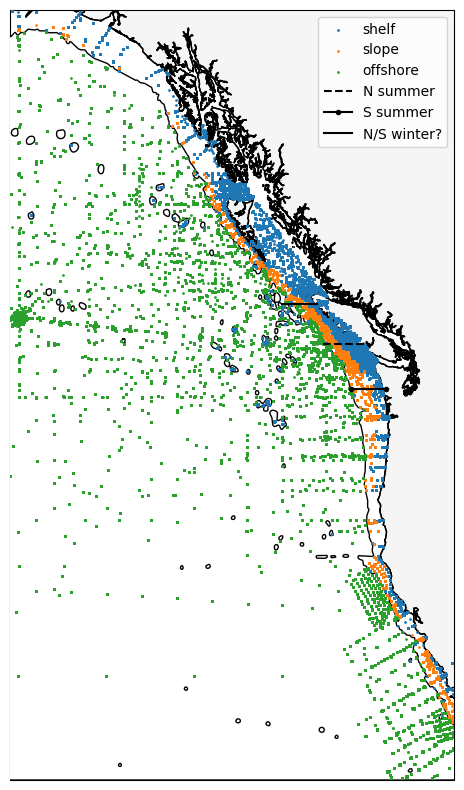

In [13]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'shelf'],obs['latitude (degrees_north)'][obs.location == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=5,label='shelf')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'slope'],obs['latitude (degrees_north)'][obs.location == 'slope'], transform=crs.PlateCarree(),s=1,zorder=5,label='slope')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'offshore'],obs['latitude (degrees_north)'][obs.location == 'offshore'], transform=crs.PlateCarree(),s=1,zorder=5,label='offshore')

#cuttoffs
ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()

In [14]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so get month from the time

obs['time']=pd.to_datetime(obs.time)
obs['month'] = [obs.time[i].month for i in obs.index]

In [15]:
# Seperating Shelf current 
obs['current'] = ""
poly = np.array([[-128.5, 50.7],
         [-127.3, 51.2],
         [-122.2, 48],
         [-124.1, 48],
         [-128.5, 50.7]])
polygon = Polygon(poly)

# Adding all points on the shelf to our overall shelf current
obs['current'][obs['location']== 'shelf'] = 'Shelf_Current'

# Removing shelf current rows that do not fulfill our minimum salinity requirements (river water)
obs = obs[~((obs['current'] == 'Shelf_Current') & (obs['salinity (g kg-1)'] < 31.5))]

# Removing shelf current rows inside inlets in Vancouver Island (polygon used here originally plotted out below)
mask = obs.apply(lambda row: polygon.contains(Point(row['longitude (degrees_east)'], row['latitude (degrees_north)'])), axis=1)
obs = obs[~mask].reset_index(drop=True)


/tmp/ipykernel_495783/3725491754.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs['current'][obs['location']== 'shelf'] = 'Shelf_Current'
/tmp/ipykernel_495783/3725491754.py:11: SettingWithCopyWarning: 
A value is trying to be set on

In [16]:
# Seperating CUC
densMin = 26.5
densMax = 26.6
depthMin = 175
depthMax = 275
obs['salinity (psu)'] = unit_conversions.teos_psu(obs['salinity (g kg-1)'])
obs['density (kg m-3)'] = psu_tools.calculate_density(obs['temperature (degC)'], obs['salinity (psu)'])-1000

# Selecting data that is on the 26.5-26.6 isopycnal and where a current is over the continental slope
mask = ((obs['density (kg m-3)'] >= densMin) # from Thomson & Krassovski 2010, Meinvielle & Johnson 2013
        & (obs['density (kg m-3)'] <= densMax) # from Thomson & Krassovski 2010, Meinvielle & Johnson 2013
        # & (obs['depth (m)'] <= depthMax) # from Thomson & Krassovski 2010
        # & (obs['depth (m)'] >= depthMin) # from Thomson & Krassovski 2010
        & (obs['latitude (degrees_north)'] < 50) # from Meinvielle & Johnson 2013
        & (obs['latitude (degrees_north)'] > 25) # from Meinvielle & Johnson 2013
        & (obs['location'] == 'slope')) # from Meinvielle & Johnson 2013
obs.loc[mask, 'current'] = 'CUC'
print(obs[mask][['depth (m)', 'density (kg m-3)', 'location']].head())
cuc_obs = obs[obs['current'] == 'CUC']
print(cuc_obs[~(cuc_obs['location'] == 'slope')])

       depth (m)  density (kg m-3) location
81436      142.0         26.518583    slope
81437      143.0         26.521357    slope
81438      145.0         26.521401    slope
81439      147.0         26.521446    slope
81440      150.0         26.529397    slope
Empty DataFrame
Columns: [Unnamed: 0, time, longitude (degrees_east), latitude (degrees_north), depth (m), pressure (dbar), temperature (degC), salinity (g kg-1), DO (umol kg-1), NO3 (uM), NO2 (uM), NH4 (uM), PO4 (uM), SiO4 (uM), Chl (mg m-3), TA (uM), DIC (uM), Carbonate, Aragonite, Calcite, Cd (nmol kg-1), Co (nmol kg-1), Cu (nmol kg-1), Fe (nmol kg-1), Mn (nmol kg-1), Ni (nmol kg-1), Zn (nmol kg-1), source, Nstar (umol kg-1), spice, current, geometry, location, month, salinity (psu), density (kg m-3)]
Index: []

[0 rows x 36 columns]


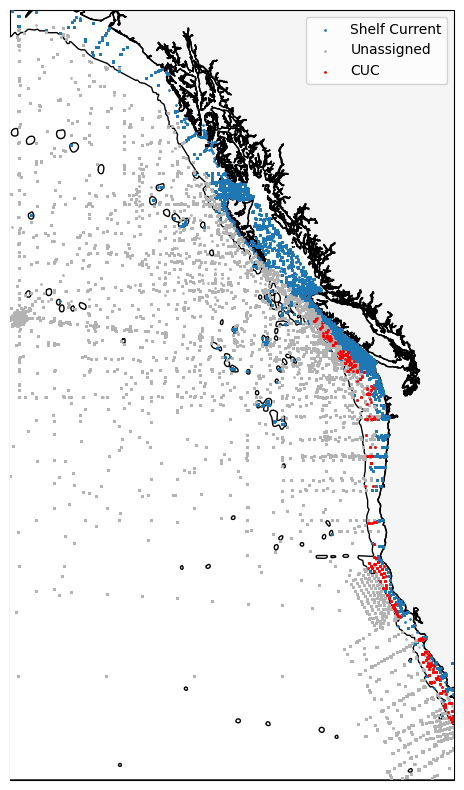

In [17]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'Shelf_Current'],obs['latitude (degrees_north)'][obs.current == 'Shelf_Current'], transform=crs.PlateCarree(),s=1,zorder=5,label='Shelf Current')
ax.scatter(obs['longitude (degrees_east)'][obs.current == ''],obs['latitude (degrees_north)'][obs.current == ''], c='0.7', transform=crs.PlateCarree(),s=1,zorder=5,label='Unassigned')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CUC'],obs['latitude (degrees_north)'][obs.current == 'CUC'], c='r', transform=crs.PlateCarree(),s=1,zorder=5,label='CUC')


#cuttoffs
# ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
# ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
# ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()

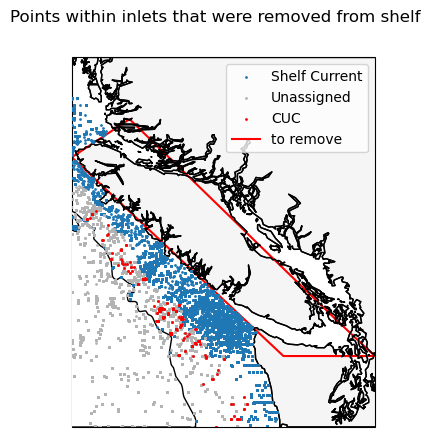

In [18]:
xlim, ylim = [-128.5, -122.2], [47, 52]

fig, ax = plt.subplots(1,1, subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'Shelf_Current'],obs['latitude (degrees_north)'][obs.current == 'Shelf_Current'], transform=crs.PlateCarree(),s=1,zorder=5,label='Shelf Current')
ax.scatter(obs['longitude (degrees_east)'][obs.current == ''],obs['latitude (degrees_north)'][obs.current == ''], c='0.7', transform=crs.PlateCarree(),s=1,zorder=5,label='Unassigned')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CUC'],obs['latitude (degrees_north)'][obs.current == 'CUC'], c='r', transform=crs.PlateCarree(),s=1,zorder=5,label='CUC')

poly = np.array([[-128.5, 50.7],
         [-127.3, 51.2],
         [-122.2, 48],
         [-124.1, 48],
         [-128.5, 50.7]])
ax.plot(poly[:,0], poly[:,1], c='r', transform=crs.PlateCarree(), label='to remove')

#cuttoffs
# ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
# ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
# ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')
plt.suptitle('Points within inlets that were removed from shelf')

ax.legend()

In [19]:
obs_cuc = obs[obs["current"] == 'CUC']
obs_cuc

,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),NO3 (uM),...,Zn (nmol kg-1),source,Nstar (umol kg-1),spice,current,geometry,location,month,salinity (psu),density (kg m-3)
81436,139246,1972-05-09 00:00:00+00:00,-126.68,48.63,142.0,143.25955,7.098297,34.033815,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.037819,CUC,POINT (-126.68 48.63),slope,5,33.874084,26.518583
81437,139247,1972-05-09 00:00:00+00:00,-126.68,48.63,143.0,144.26877,7.078301,34.033843,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.040765,CUC,POINT (-126.68 48.63),slope,5,33.874112,26.521357
81438,139248,1972-05-09 00:00:00+00:00,-126.68,48.63,145.0,146.28723,7.078301,34.033900,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.040725,CUC,POINT (-126.68 48.63),slope,5,33.874168,26.521401
81439,139249,1972-05-09 00:00:00+00:00,-126.68,48.63,147.0,148.30571,7.078301,34.033956,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.040685,CUC,POINT (-126.68 48.63),slope,5,33.874224,26.521446
81440,139250,1972-05-09 00:00:00+00:00,-126.68,48.63,150.0,151.33347,7.078301,34.044101,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.033401,CUC,POINT (-126.68 48.63),slope,5,33.884322,26.529397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140098,2655402,2024-08-22 00:00:00+00:00,-124.95,44.37,0.0,0.00000,7.330787,34.121369,93.260732,NaN,...,NaN,ooi,NaN,0.059917,CUC,POINT (-124.95 44.37),slope,8,33.961227,26.554820
1140111,2655424,2024-08-23 00:00:00+00:00,-124.95,44.37,0.0,0.00000,7.386125,34.138650,101.938706,NaN,...,NaN,ooi,NaN,0.080728,CUC,POINT (-124.95 44.37),slope,8,33.978427,26.560557
1140125,2655447,2024-08-24 00:00:00+00:00,-124.95,44.37,0.0,0.00000,7.401760,34.117958,112.628501,NaN,...,NaN,ooi,NaN,0.068228,CUC,POINT (-124.95 44.37),slope,8,33.957832,26.542145
1140139,2655470,2024-08-25 00:00:00+00:00,-124.95,44.37,0.0,0.00000,7.453199,34.119421,115.467806,NaN,...,NaN,ooi,NaN,0.077114,CUC,POINT (-124.95 44.37),slope,8,33.959289,26.536007


Text(0, 0.5, 'depth (m)')

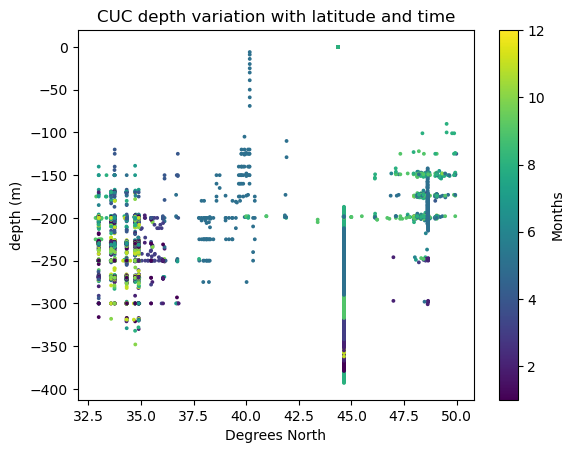

In [20]:


sc = plt.scatter(obs_cuc['latitude (degrees_north)'], -obs_cuc['depth (m)'], c=obs_cuc['month'], cmap='viridis', s=3, vmin=1, vmax=12)
plt.colorbar(sc, orientation='vertical', label='Months')
plt.title('CUC depth variation with latitude and time')
plt.xlabel('Degrees North')
plt.ylabel('depth (m)')
# sc = ax.scatter(lon0m, lat0m, transform=crs.PlateCarree(), c=chl0m, cmap='viridis', s=3, vmin=0, vmax=45)
# cbar = fig.colorbar(sc, ax=ax, orientation='vertical', label='Chlorophyll at Surface (mg m^-3)')

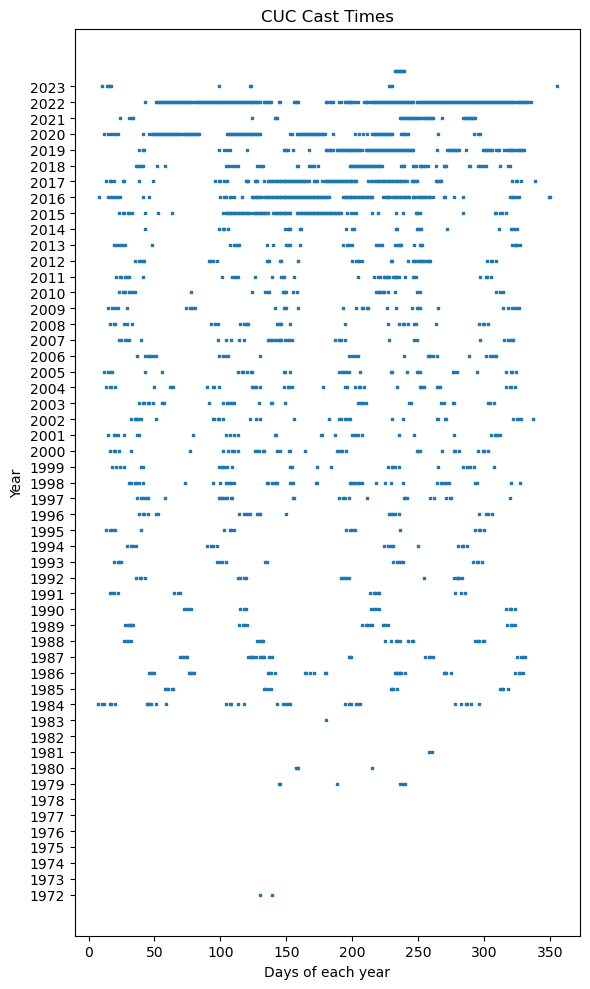

In [21]:
# plt.scatter(obs_cuc['time'], np.ones(len(obs_cuc)))

fig, ax = plt.subplots(figsize=(6, 10))

obs_cuc_dd = obs_cuc.drop_duplicates(subset='time', keep='first')

yearDay = obs_cuc_dd['time'].dt.dayofyear
year = obs_cuc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CUC Cast Times')
ax.set_yticks(range(1972, 2024))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()

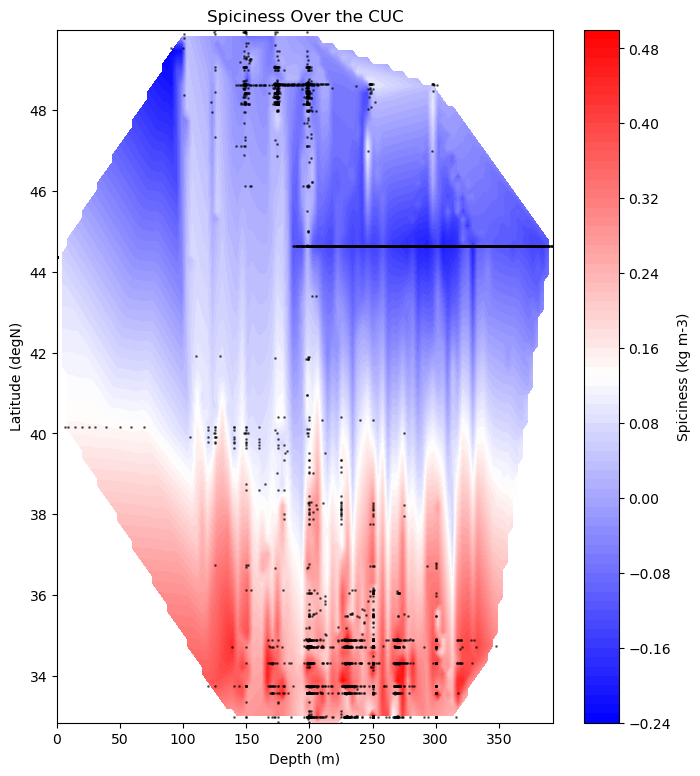

In [22]:
# Spiciness as a function of depth and latitude along CUC
x = obs_cuc['depth (m)'] 
y = obs_cuc['latitude (degrees_north)'] 
z = obs_cuc['spice']  # scalar field 

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x, y), z, (xi, yi), method='linear')

# Make the contour plot
plt.figure(figsize=(8, 9))
cp = plt.contourf(xi, yi, zi, levels=80, cmap='bwr')
plt.colorbar(cp, label='Spiciness (kg m-3)')
plt.scatter(x, y, s=1, c='k', alpha=0.5)
plt.xlabel('Depth (m)')
plt.ylabel('Latitude (degN)')
plt.title('Spiciness Over the CUC')
plt.show()

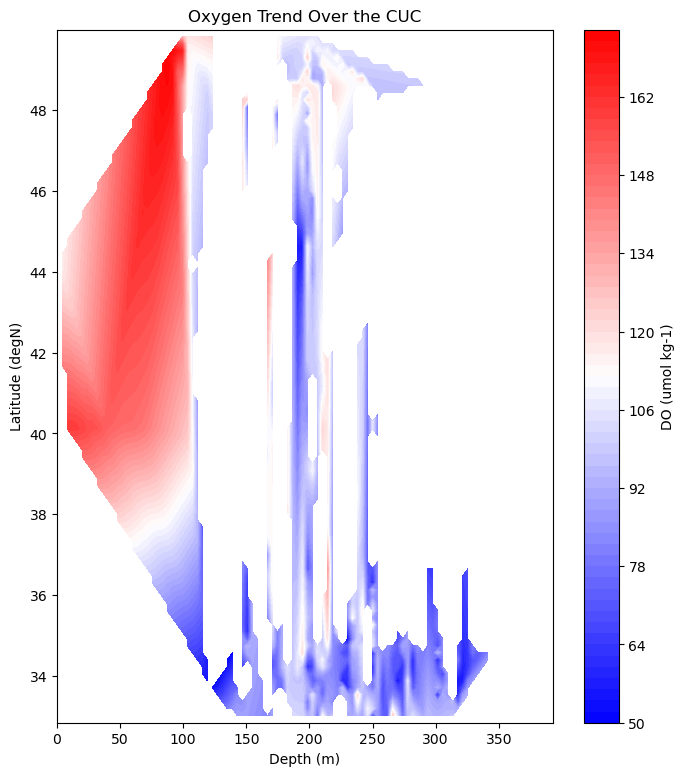

,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),NO3 (uM),...,Zn (nmol kg-1),source,Nstar (umol kg-1),spice,current,geometry,location,month,salinity (psu),density (kg m-3)
81436,139246,1972-05-09 00:00:00+00:00,-126.68,48.63,142.0,143.25955,7.098297,34.033815,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.037819,CUC,POINT (-126.68 48.63),slope,5,33.874084,26.518583
81437,139247,1972-05-09 00:00:00+00:00,-126.68,48.63,143.0,144.26877,7.078301,34.033843,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.040765,CUC,POINT (-126.68 48.63),slope,5,33.874112,26.521357
81438,139248,1972-05-09 00:00:00+00:00,-126.68,48.63,145.0,146.28723,7.078301,34.033900,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.040725,CUC,POINT (-126.68 48.63),slope,5,33.874168,26.521401
81439,139249,1972-05-09 00:00:00+00:00,-126.68,48.63,147.0,148.30571,7.078301,34.033956,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.040685,CUC,POINT (-126.68 48.63),slope,5,33.874224,26.521446
81440,139250,1972-05-09 00:00:00+00:00,-126.68,48.63,150.0,151.33347,7.078301,34.044101,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.033401,CUC,POINT (-126.68 48.63),slope,5,33.884322,26.529397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140098,2655402,2024-08-22 00:00:00+00:00,-124.95,44.37,0.0,0.00000,7.330787,34.121369,93.260732,NaN,...,NaN,ooi,NaN,0.059917,CUC,POINT (-124.95 44.37),slope,8,33.961227,26.554820
1140111,2655424,2024-08-23 00:00:00+00:00,-124.95,44.37,0.0,0.00000,7.386125,34.138650,101.938706,NaN,...,NaN,ooi,NaN,0.080728,CUC,POINT (-124.95 44.37),slope,8,33.978427,26.560557
1140125,2655447,2024-08-24 00:00:00+00:00,-124.95,44.37,0.0,0.00000,7.401760,34.117958,112.628501,NaN,...,NaN,ooi,NaN,0.068228,CUC,POINT (-124.95 44.37),slope,8,33.957832,26.542145
1140139,2655470,2024-08-25 00:00:00+00:00,-124.95,44.37,0.0,0.00000,7.453199,34.119421,115.467806,NaN,...,NaN,ooi,NaN,0.077114,CUC,POINT (-124.95 44.37),slope,8,33.959289,26.536007


In [23]:
# DO as a function of depth and latitude along CUC
x = obs_cuc['depth (m)'] 
y = obs_cuc['latitude (degrees_north)'] 
z = obs_cuc['DO (umol kg-1)']  # scalar field 

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x, y), z, (xi, yi), method='linear')

# Make the contour plot
plt.figure(figsize=(8, 9))
cp = plt.contourf(xi, yi, zi, levels=80, cmap='bwr')
plt.colorbar(cp, label='DO (umol kg-1)')
plt.xlabel('Depth (m)')
plt.ylabel('Latitude (degN)')
plt.title('Oxygen Trend Over the CUC')
plt.show()
obs_cuc

/tmp/ipykernel_495783/3499969724.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_obs['cast_id'] = cc_obs.groupby(['time', "longitude (degrees_east)", "latitude (degrees_north)"]).ngroup()
/tmp/ipykernel_495783/3499969724.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_obs.sort_values(by=['cast_id', 'depth (m)'], inplace=True)
/tmp/ipykernel_495783/3499969724.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

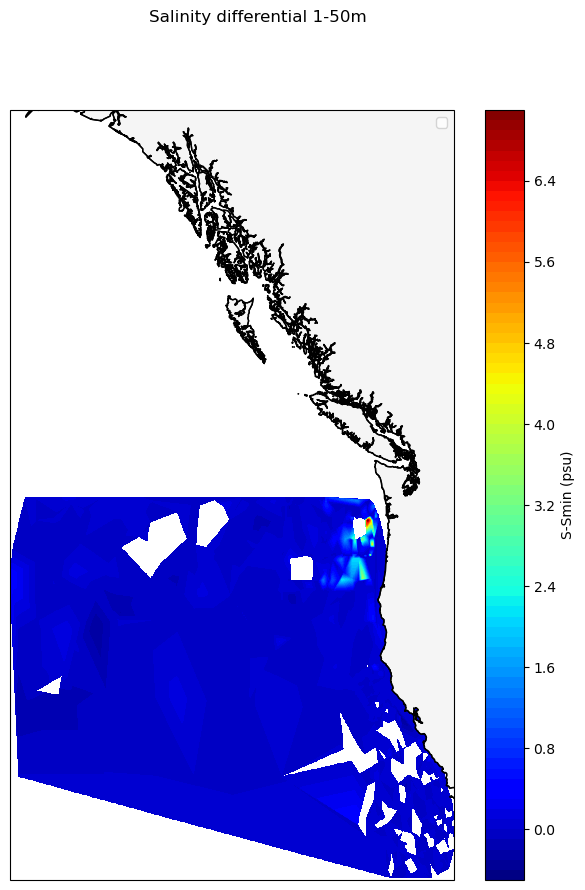

In [34]:
# Seperating California Current by Salinity field definition
S_threshold = 0.5
max_lat = 47

# Selecting data
mask = ((obs['current'] == '')
        & (obs['latitude (degrees_north)'] < max_lat))

cc_obs = obs[mask]

cc_obs['cast_id'] = cc_obs.groupby(['time', "longitude (degrees_east)", "latitude (degrees_north)"]).ngroup()
cc_obs.sort_values(by=['cast_id', 'depth (m)'], inplace=True)
cc_obs['is_cast'] = cc_obs['cast_id'].duplicated(keep=False)

smin = (
    cc_obs[cc_obs['is_cast']]
    .sort_values('depth (m)')
    .groupby('cast_id', as_index=False)
    .first()[['cast_id', 'salinity (psu)']]
    .rename(columns={'salinity (psu)': 'Smin'})
)
cc_obs = cc_obs.merge(smin, on='cast_id', how='left')
cc_obs['S-Smin'] = cc_obs['salinity (psu)'] - cc_obs['Smin']
cc_obs.loc[~cc_obs['is_cast'], 'S-Smin'] = pd.NA

up_thres = 1
low_thres = 50

depth_mask = ((cc_obs['depth (m)'] >= up_thres) & (cc_obs['depth (m)'] <= low_thres) & (cc_obs['is_cast']))
x = cc_obs['longitude (degrees_east)'][depth_mask]
y = cc_obs['latitude (degrees_north)'][depth_mask] 
z = cc_obs['S-Smin'][depth_mask]  # scalar field 

xi = np.linspace(min(x), max(x), 500)
yi = np.linspace(min(y), max(y), 500)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method='linear')

xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))
cp = ax.contourf(xi, yi, zi, levels=80, cmap='jet', transform=crs.PlateCarree())
fig.colorbar(cp, label='S-Smin (psu)')
ax.set_xlabel('Longitude (degE)')
ax.set_ylabel('Latitude (degN)')
plt.suptitle('Salinity differential 1-50m')
ax.legend()